In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from deepexperiment.utils import one_hot_encoding, one_hot_encoding_batch, ResBlock, get_indices
from deepexperiment.methods import GradCam, DeepShap
from deepexperiment.clustering import cluster_attention, compute_cluster_consensus

# Loading model and data

In [3]:
model = keras.models.load_model("../models/resnet_small_committee.h5")

2022-09-13 12:39:54.570753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/katarina/git/DeepExperiment/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-09-13 12:39:54.570778: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-13 12:39:54.570793: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (katarina-lenovo): /proc/driver/nvidia/version does not exist
2022-09-13 12:39:54.570984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
samples = pd.read_csv('../data/evaluation_set_1_1_CLASH2013_paper.tsv', sep='\t')
pos_samples = samples[samples['label'] == 1].reset_index(drop=True)
neg_samples = samples[samples['label'] == 0].reset_index(drop=True)

In [5]:
true_positive_indices = get_indices(pos_samples, model, lambda x: x[1] > x[0])
print(len(pos_samples))
print(len(true_positive_indices))

32/32 [==============================] - 2s 40ms/step
1000
552


In [6]:
data, _ = one_hot_encoding_batch(pos_samples.iloc[true_positive_indices].reset_index(drop=True))

# Computing attention maps

## GradCam

In [ ]:
gradCam = GradCam(model)

In [7]:
heatmaps = [gradCam(d[np.newaxis, :,  :, :], pred_index=1) for d in data]
heatmaps = np.array(heatmaps)

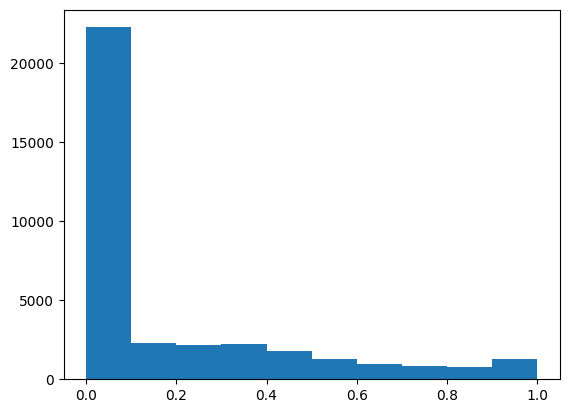

In [14]:
plt.hist(heatmaps.flatten())
plt.show()

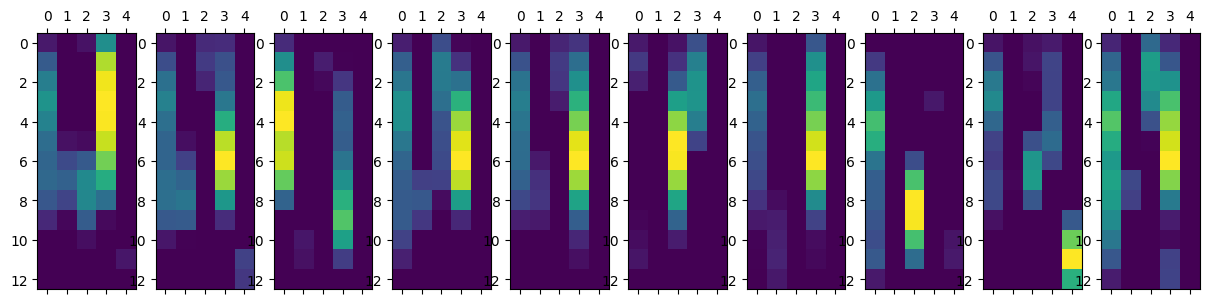

In [18]:
fig, ax = plt.subplots(1,10, figsize=(15, 15))
for i in range(10):
  ax[i].matshow(heatmaps[i])

In [28]:
def attention_dist(a1, a2):
  #dist = 0
  #for x in range(a1.shape[0]):
  #  for y in range(a1.shape[1]):
  #    dist += (a1[x,y,0] - a2[x,y,0])**2
  #return dist
  return np.linalg.norm(a1-a2)
  #xx = a1.reshape(2, -1)
  #yy = a2.reshape(2, -1)
  #dist = np.hypot(*(xx - yy))
  #return dist

In [30]:
for i in range(10):
    print(attention_dist(heatmaps[0], heatmaps[i]))

0.0
1.5925654
2.5403695
1.6181186
1.3310382
2.5695994
1.2458999
2.7842557
2.446218
1.8387281


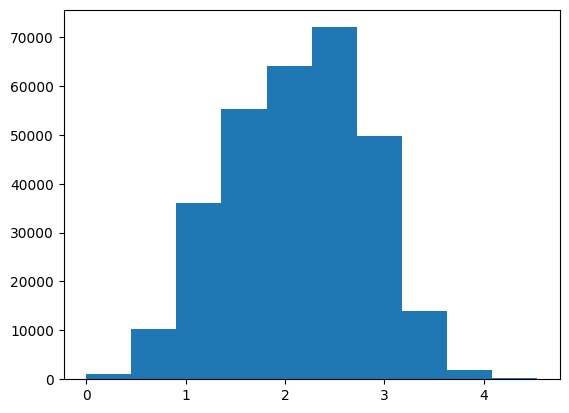

In [58]:
dist = []
for i in range(len(heatmaps)):
    row = []
    for j in range(len(heatmaps)):
        row.append(attention_dist(heatmaps[i], heatmaps[j]))
    dist.append(row)

plt.hist(np.array(dist).flatten())
plt.show()

In [16]:
np.save('../data/evaluation_set_1_1_CLAHS2013_paper_gradcam_tp.npy', heatmaps)

## GradCam all layers

In [8]:
heatmaps_all = [gradCam(d[np.newaxis, :,  :, :], pred_index=1, last_conv_layer_name='all') for d in data]
heatmaps_all = np.array(heatmaps_all)

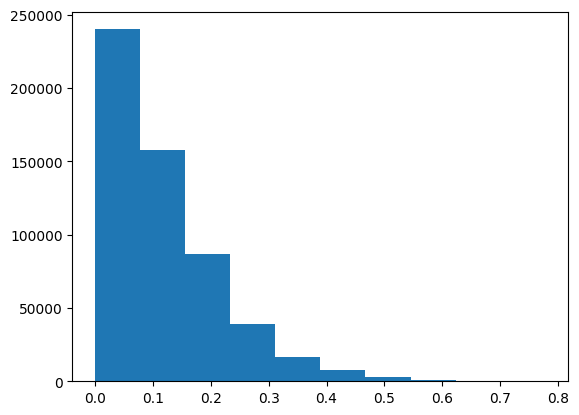

In [15]:
plt.hist(heatmaps_all.flatten())
plt.show()

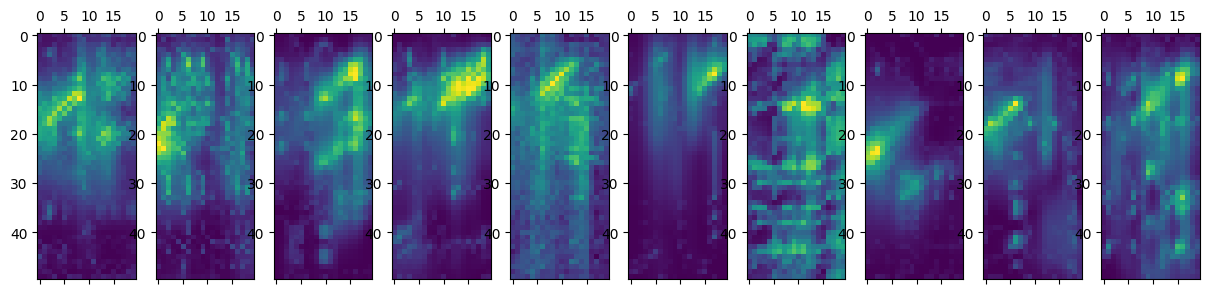

In [19]:
fig, ax = plt.subplots(1,10, figsize=(15, 15))
for i in range(10):
  ax[i].matshow(heatmaps_all[i])

In [31]:
for i in range(10):
    print(attention_dist(heatmaps_all[0], heatmaps_all[i]))

0.0
2.4735918
2.9481208
2.7623923
2.185378
3.1228588
4.000482
4.1088395
2.6708553
2.906651


In [53]:
heatmaps_all.shape

(552, 50, 20)

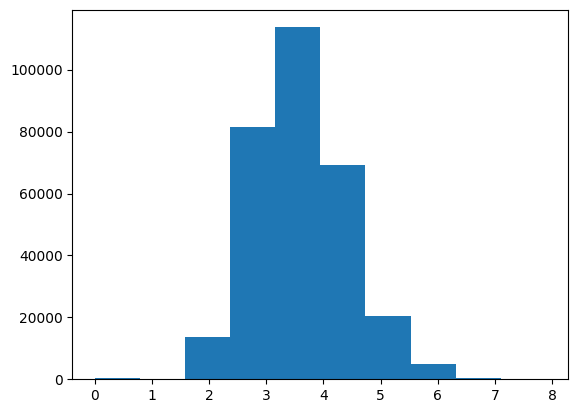

In [57]:
dist = []
for i in range(len(heatmaps_all)):
    row = []
    for j in range(len(heatmaps_all)):
        row.append(attention_dist(heatmaps_all[i], heatmaps_all[j]))
    dist.append(row)

plt.hist(np.array(dist).flatten())
plt.show()

In [17]:
np.save('../data/evaluation_set_1_1_CLAHS2013_paper_gradcamall_tp.npy', heatmaps_all)

## DeepShap

In [20]:
rand_samples = samples.sample(n=100, replace=False, random_state=42).reset_index(drop=True)
background, _ = one_hot_encoding_batch(rand_samples)

In [21]:
from deepexperiment.methods import GradCam, DeepShap

deepShap = DeepShap(model, background)
attribution = deepShap(data)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [23]:
pos_shaps = attribution[1][:,:,:,0]
pos_shaps = np.array(pos_shaps)

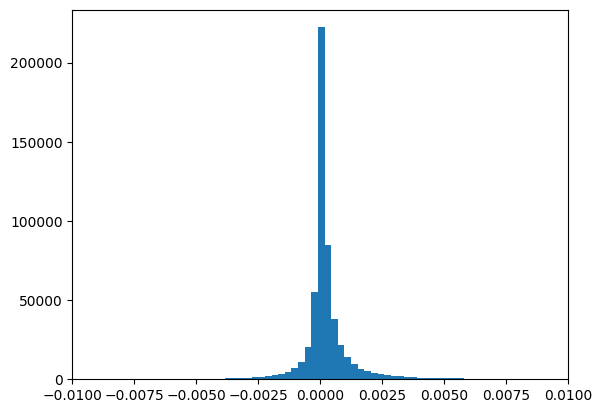

In [71]:
plt.hist(pos_shaps.flatten(), bins=5000)
plt.xlim(xmin=-0.01, xmax = 0.01)
plt.show()

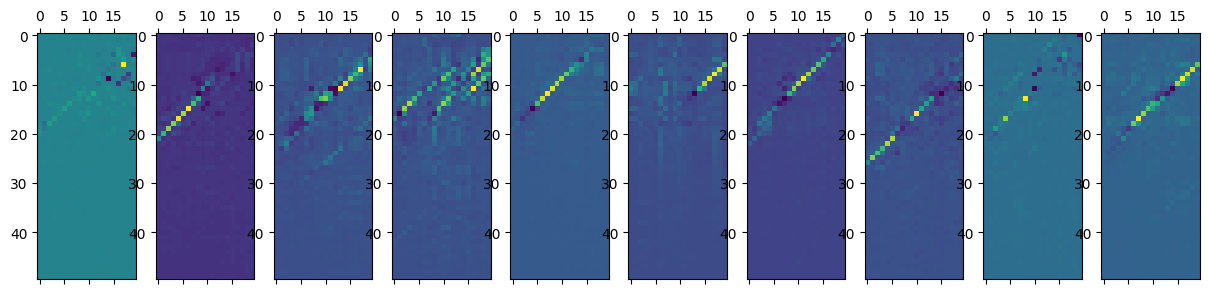

In [25]:
fig, ax = plt.subplots(1,10, figsize=(15, 15))
for i in range(10):
  ax[i].matshow(pos_shaps[i])

In [32]:
for i in range(10):
    print(attention_dist(pos_shaps[0], pos_shaps[i]))

0.0
0.9084164476052422
0.8950824184774265
0.9083882651245232
0.9110752789062619
0.9009617523939896
0.8972758237527684
0.9046517795165363
1.2179895698628858
0.9096082868115627


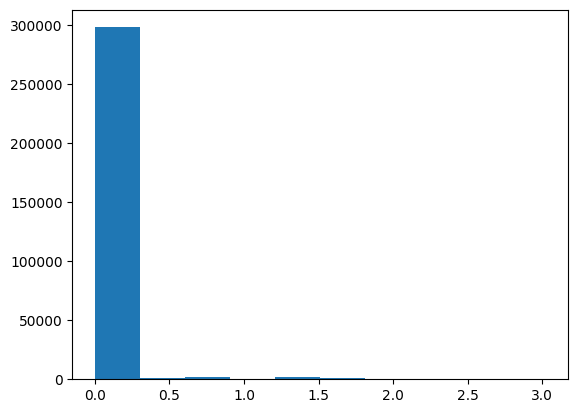

In [62]:
import math

dist = []
for i in range(len(pos_shaps)):
    row = []
    for j in range(len(pos_shaps)):
        row.append(attention_dist(pos_shaps[i], pos_shaps[j]))
    dist.append(row)

plt.hist(np.array(dist).flatten())
plt.show()

In [26]:
np.save('../data/evaluation_set_1_1_CLAHS2013_paper_shaps_tp.npy', pos_shaps)

## DeepShap normalized

In [170]:
pos_shaps_filter = pos_shaps.copy()

In [173]:
pos_shaps_filter = np.array([p / np.max(np.abs(p)) for p in pos_shaps_filter])

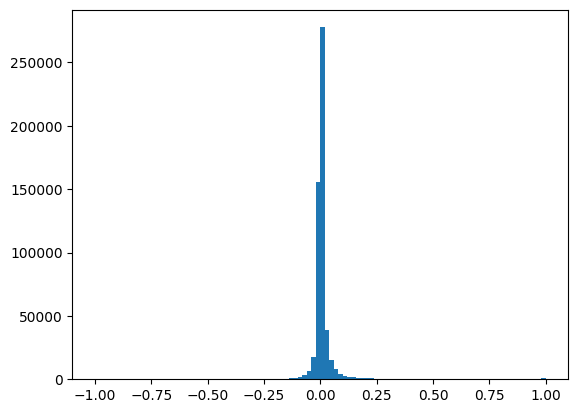

In [174]:
plt.hist(pos_shaps_filter.flatten(), bins=100)
plt.show()

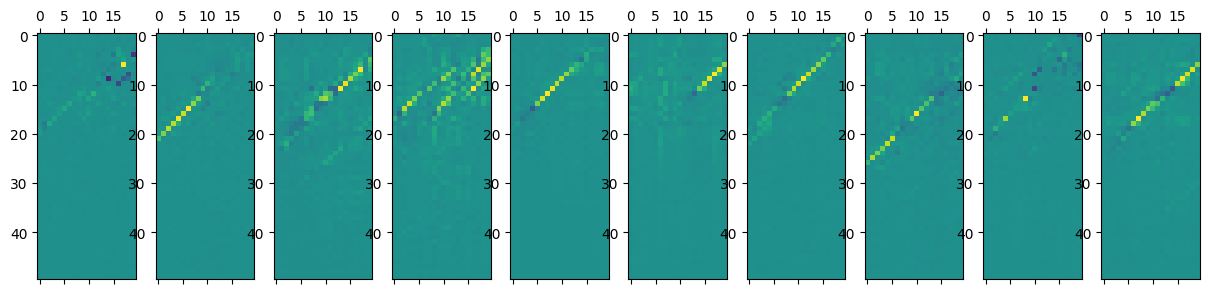

In [179]:
fig, ax = plt.subplots(1,10, figsize=(15, 15))
for i in range(10):
  ax[i].matshow(pos_shaps_filter[i], vmin=-1, vmax=1)

In [196]:
for i in range(len(pos_shaps_filter)):
  pos_shaps_filter[i][(pos_shaps_filter[i] < 0.15) & (pos_shaps_filter[i] > -0.15)] = 0

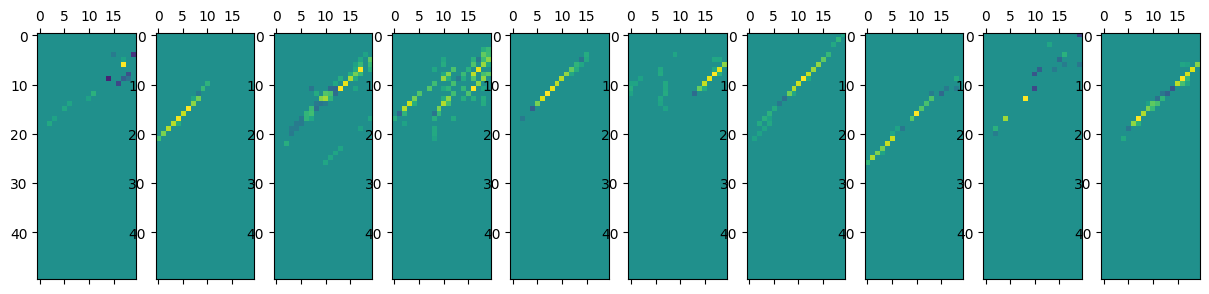

In [197]:
fig, ax = plt.subplots(1,10, figsize=(15, 15))
for i in range(10):
  ax[i].matshow(pos_shaps_filter[i], vmin=-1, vmax=1)

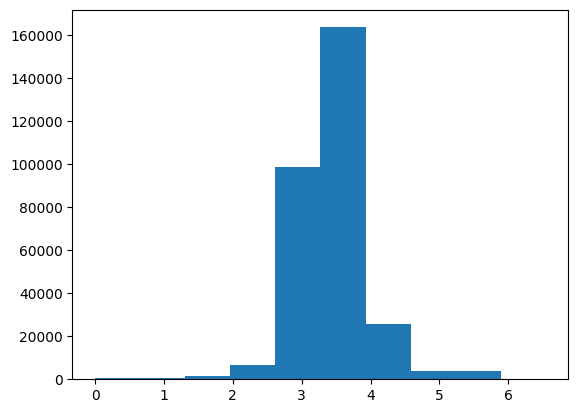

In [198]:
import math

dist = []
for i in range(len(pos_shaps_filter)):
    row = []
    for j in range(len(pos_shaps_filter)):
        row.append(attention_dist(pos_shaps_filter[i], pos_shaps_filter[j]))
    dist.append(row)

plt.hist(np.array(dist).flatten())
plt.show()

## Model flatten

In [209]:
model = keras.models.load_model("../models/resnet_small_committee.h5")
model = tf.keras.Model(inputs = model.inputs, outputs = model.layers[-2].output)
model.summary()

Model: "model_9385"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 20, 1)]       0         
                                                                 
 batch_normalization_90 (Bat  (None, 50, 20, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_93 (Conv2D)          (None, 50, 20, 16)        160       
                                                                 
 re_lu_87 (ReLU)             (None, 50, 20, 16)        0         
                                                                 
 batch_normalization_91 (Bat  (None, 50, 20, 16)       64        
 chNormalization)                                                
                                                                 
 dropout_45 (Dropout)        (None, 50, 20, 16)        0

In [210]:
features = model.predict(data)

18/18 [==============================] - 1s 35ms/step


In [211]:
features.shape

(552, 192)

In [135]:
pos_shaps_filter.shape

(552, 50, 20)

In [199]:
pos_shaps_flat = [pos_shap.flatten() for pos_shap in pos_shaps_filter]

In [219]:
from sklearn.cluster import KMeans

N_CLUSTERS=10
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=22)
kmeans.fit(pos_shaps_flat)

KMeans(n_clusters=10, random_state=22)

In [220]:
labels = kmeans.labels_
labels

array([2, 8, 2, 6, 9, 6, 4, 2, 2, 6, 4, 2, 2, 7, 9, 3, 4, 2, 2, 5, 2, 3,
       2, 4, 9, 0, 7, 7, 3, 7, 0, 2, 2, 4, 2, 2, 8, 9, 2, 2, 5, 7, 2, 1,
       2, 2, 8, 5, 5, 6, 2, 6, 2, 3, 9, 9, 1, 2, 6, 9, 5, 9, 2, 2, 4, 7,
       3, 4, 2, 0, 8, 2, 5, 4, 6, 4, 9, 5, 3, 2, 3, 5, 0, 0, 9, 5, 7, 2,
       0, 2, 2, 5, 4, 5, 6, 8, 2, 5, 2, 0, 1, 9, 6, 2, 8, 1, 9, 2, 8, 2,
       9, 9, 5, 2, 7, 2, 3, 2, 2, 3, 2, 8, 9, 6, 7, 6, 9, 9, 1, 2, 8, 1,
       8, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 4, 2, 0, 2, 5, 1, 5, 9, 9, 9, 5,
       2, 2, 2, 0, 9, 2, 2, 7, 9, 5, 2, 2, 7, 2, 1, 5, 8, 5, 2, 5, 8, 9,
       2, 9, 0, 5, 8, 9, 4, 4, 2, 2, 3, 9, 9, 2, 7, 7, 4, 2, 1, 6, 2, 5,
       9, 2, 2, 2, 6, 2, 5, 2, 7, 9, 6, 2, 3, 8, 9, 5, 9, 9, 5, 8, 6, 8,
       9, 7, 3, 2, 9, 2, 2, 2, 2, 2, 7, 1, 1, 7, 4, 3, 6, 7, 7, 1, 8, 1,
       2, 4, 6, 2, 4, 9, 1, 9, 5, 7, 1, 5, 0, 9, 2, 3, 2, 4, 9, 2, 9, 9,
       3, 2, 1, 3, 2, 6, 2, 3, 2, 2, 7, 8, 2, 5, 2, 8, 0, 2, 1, 3, 9, 6,
       2, 8, 2, 7, 8, 9, 5, 1, 9, 5, 2, 2, 8, 6, 8,

(array([ 22.,  38., 183.,  33.,  31.,  44.,  45.,  38.,  41.,  77.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

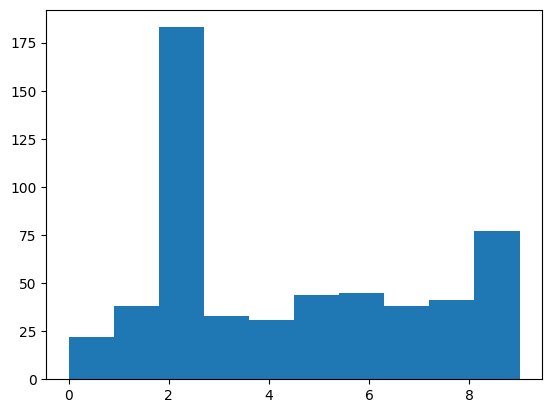

In [221]:
plt.hist(labels,bins=N_CLUSTERS)

In [222]:
clusters = compute_cluster_consensus(pos_shaps_filter, labels)

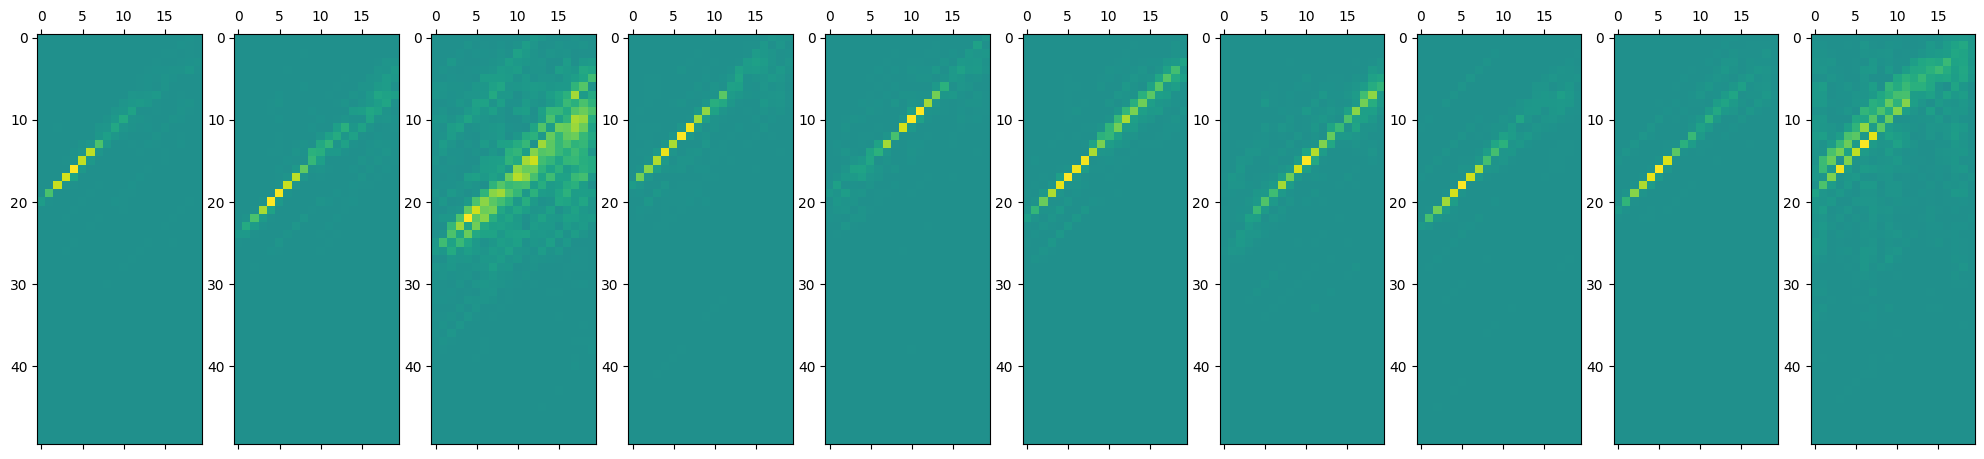

In [223]:
fig, ax = plt.subplots(1,N_CLUSTERS, figsize=(25, 25))
for i in range(N_CLUSTERS):
  ax[i].matshow(clusters[i], vmin=-1, vmax=1)

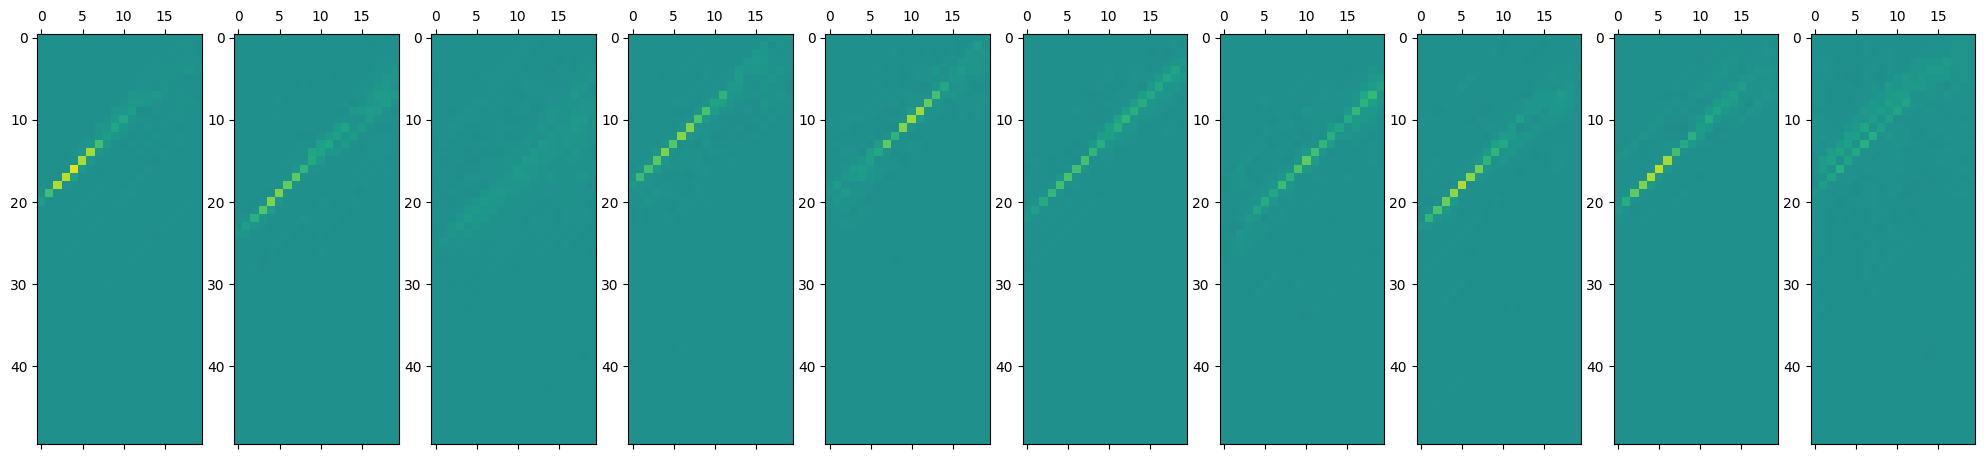

In [228]:
fig, ax = plt.subplots(1,N_CLUSTERS, figsize=(25, 25))
for i, center in enumerate(kmeans.cluster_centers_):
  ax[i].matshow(center.reshape((50,20)), vmin=-1, vmax=1)

# Target site

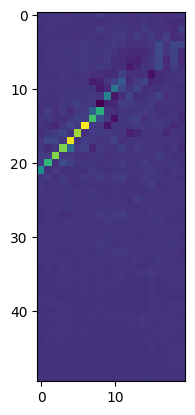

In [244]:
plt.imshow(pos_shaps[1])

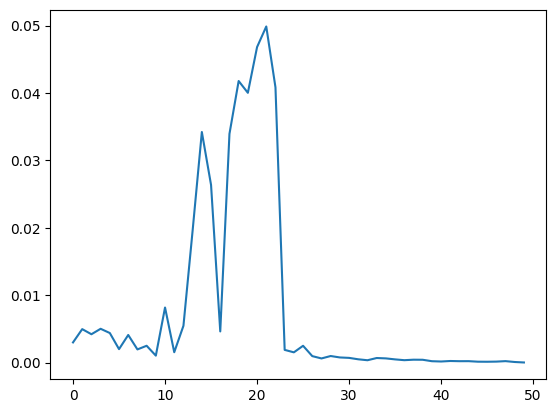

In [275]:
plt.plot(np.max(pos_shaps[27], axis=1))

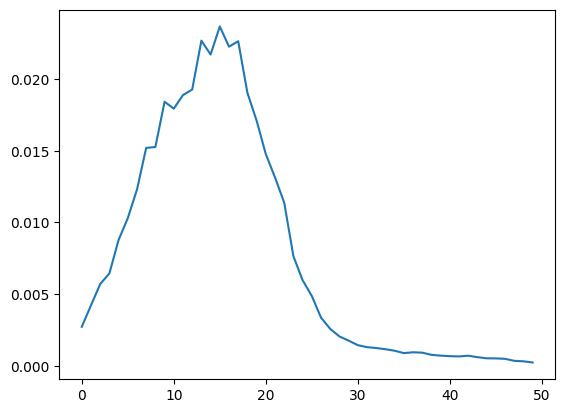

In [280]:
plt.plot(np.mean([np.max(shap, axis=1) for shap in pos_shaps], axis=0))

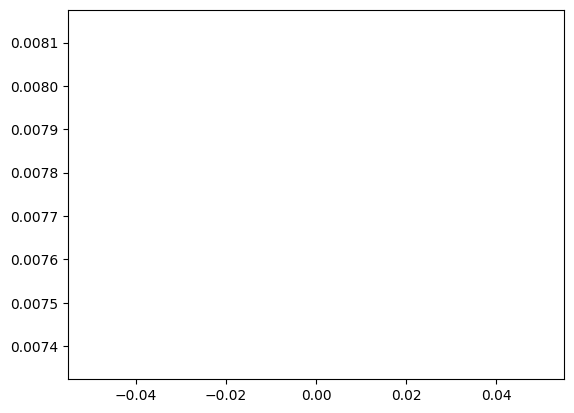

In [277]:
plt.plot(target_site)

# Clustering

## GradCam

In [38]:
heatmaps = np.load('../data/evaluation_set_1_1_CLAHS2013_paper_gradcam_tp.npy')

In [229]:
def compute_dist(attentins, dist_function):
    dist = []
    for i in range(len(attentins)):
        row = []
        for j in range(len(attentins)):
            row.append(dist_function(attentins[i], attentins[j]))
        dist.append(row)
    return dist

In [230]:
from sklearn.cluster import AgglomerativeClustering

N_CLUSTERS = 10
dist = compute_dist(heatmaps, attention_dist)
clustering = AgglomerativeClustering(n_clusters=N_CLUSTERS, affinity="precomputed", linkage='complete').fit(dist)
labels =  clustering.labels_

(array([ 59., 219.,  44., 126.,  22.,  45.,  19.,   7.,   1.,  10.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

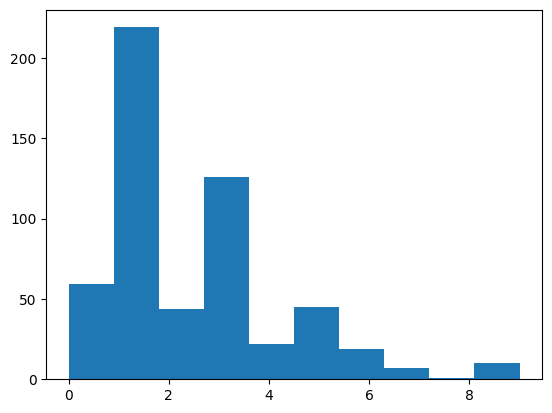

In [231]:
plt.hist(labels)

In [232]:
clusters = compute_cluster_consensus(heatmaps, labels)

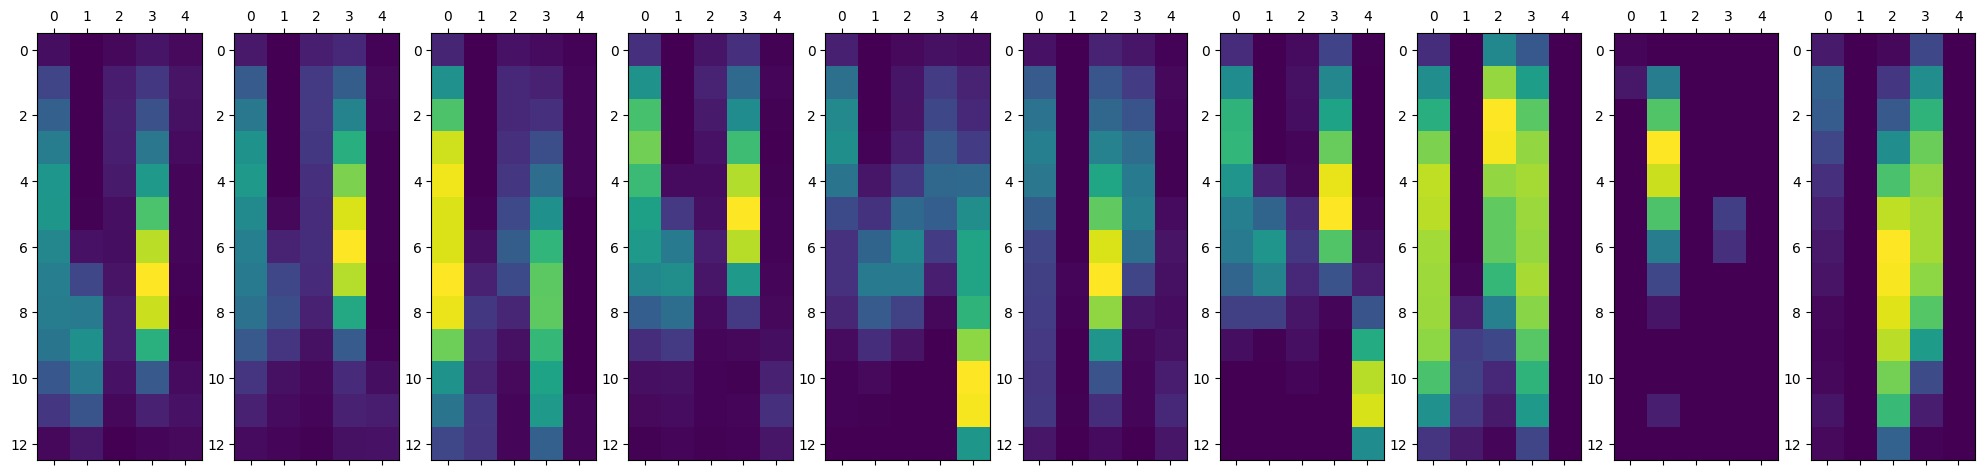

In [233]:
fig, ax = plt.subplots(1,N_CLUSTERS, figsize=(25, 25))
for i in range(N_CLUSTERS):
  ax[i].matshow(clusters[i])

In [236]:
def show_label_examples(data, labels, label, n_samples):
    fig, ax = plt.subplots(1,n_samples, figsize=(15, 15))
    for i, sample in enumerate(data[labels == label][:n_samples]):
        ax[i].matshow(sample)

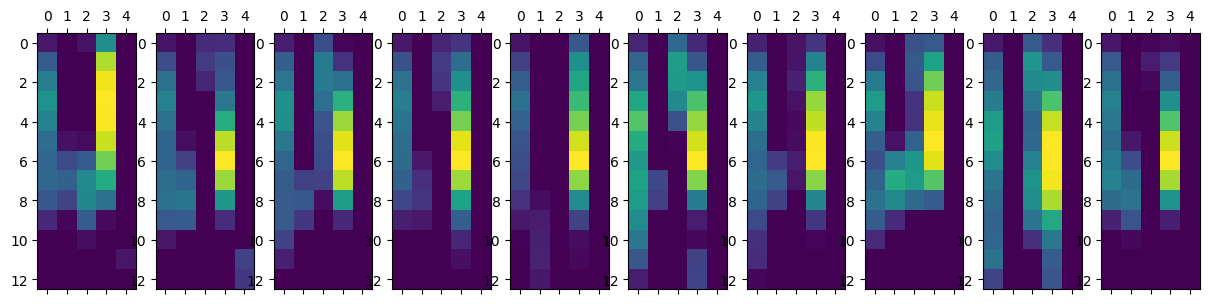

In [241]:
show_label_examples(heatmaps, labels, 1, 10)

## GradCam all layers

In [43]:
heatmaps_all = np.load('../data/evaluation_set_1_1_CLAHS2013_paper_gradcamall_tp.npy')

In [44]:
N_CLUSTERS = 10
labels = cluster_attention(heatmaps_all, attention_dist, N_CLUSTERS)

(array([ 34., 102.,  89.,   2.,  84.,  10., 152.,  14.,  62.,   3.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

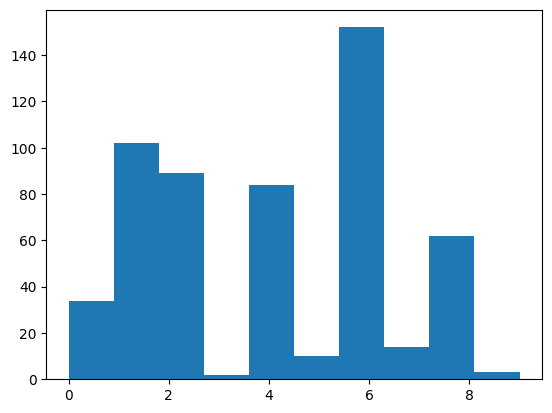

In [45]:
plt.hist(labels)

In [47]:
clusters = compute_cluster_consensus(heatmaps_all, labels)

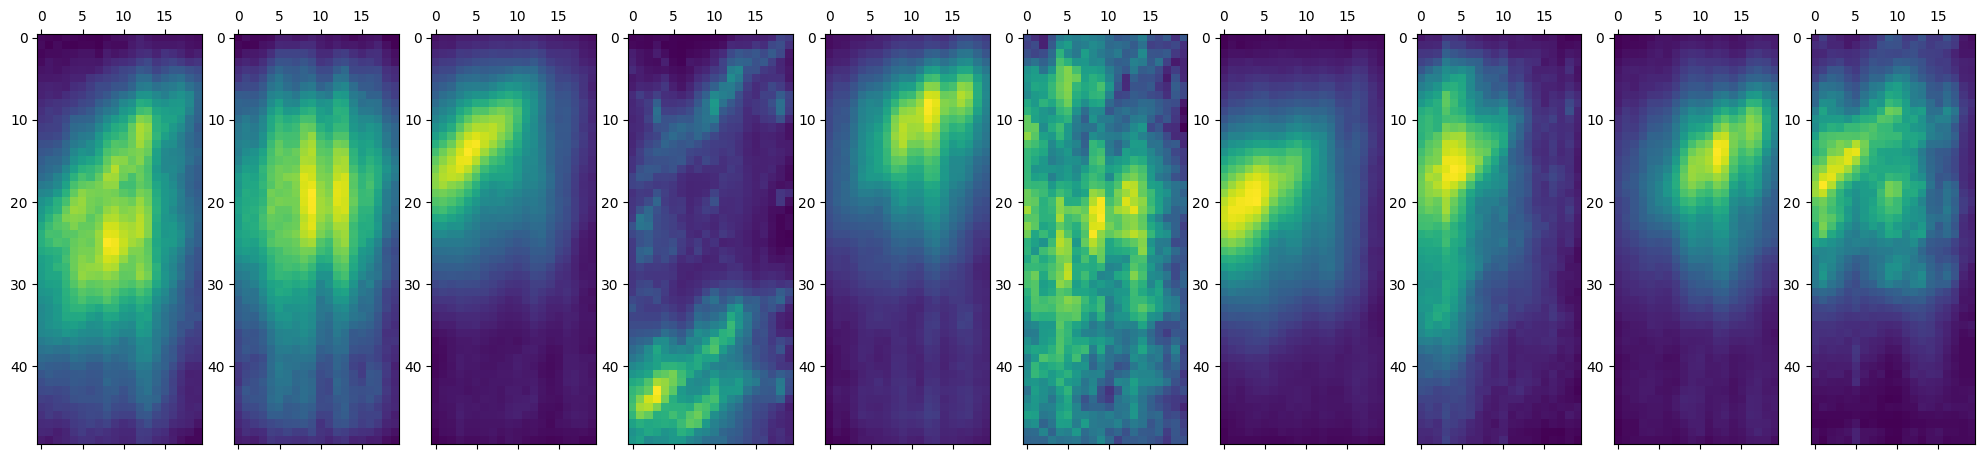

In [48]:
fig, ax = plt.subplots(1,N_CLUSTERS, figsize=(25, 25))
for i in range(N_CLUSTERS):
  ax[i].matshow(clusters[i])

## DeepShap

In [49]:
shaps = np.load('../data/evaluation_set_1_1_CLAHS2013_paper_shaps_tp.npy')

In [100]:
N_CLUSTERS = 5
labels = cluster_attention(pos_shaps_filter, attention_dist, N_CLUSTERS)

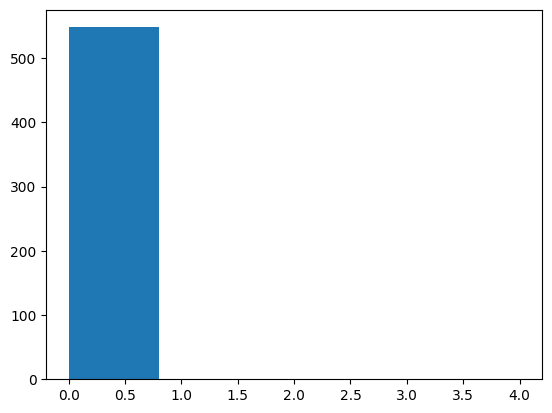

In [99]:
plt.hist(labels, bins=N_CLUSTERS);

In [101]:
dist = []
for i in range(len(pos_shaps_filter)):
    row = []
    for j in range(len(pos_shaps_filter)):
        row.append(attention_dist(pos_shaps_filter[i], pos_shaps_filter[j]))
    dist.append(row)


In [106]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

condensed_dist_matrix = squareform(dist)
Z = linkage(condensed_dist_matrix, method='complete', optimal_ordering=False)

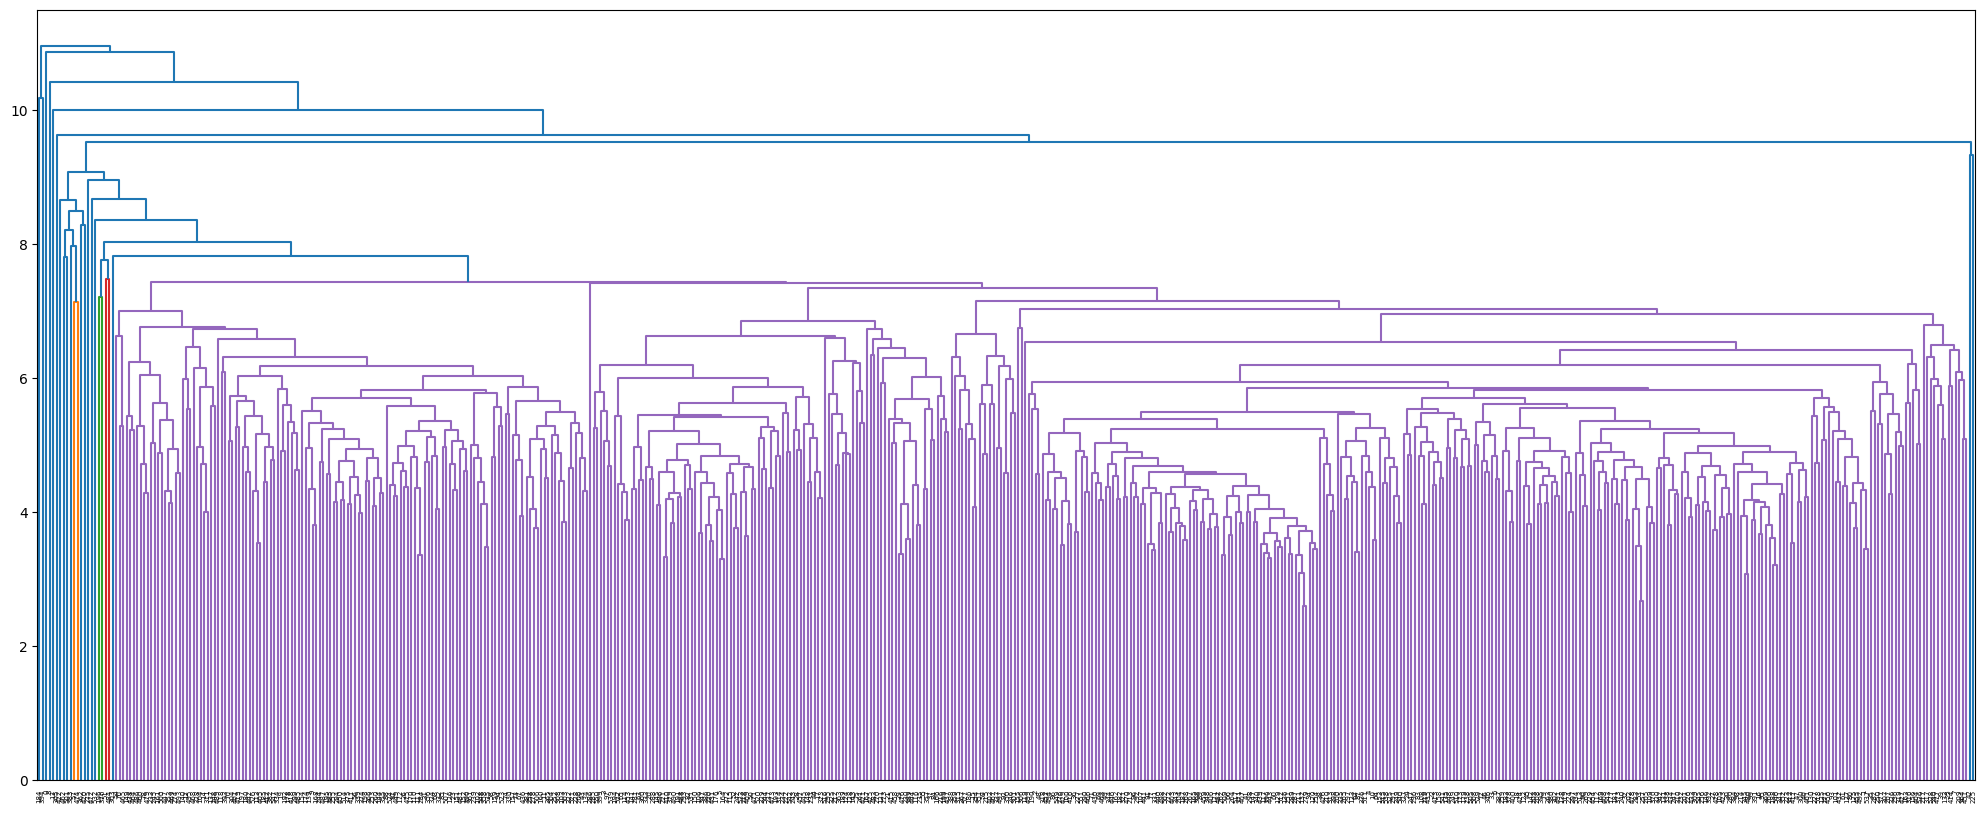

In [107]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [109]:
from scipy.cluster.hierarchy import complete

Z = complete(condensed_dist_matrix)

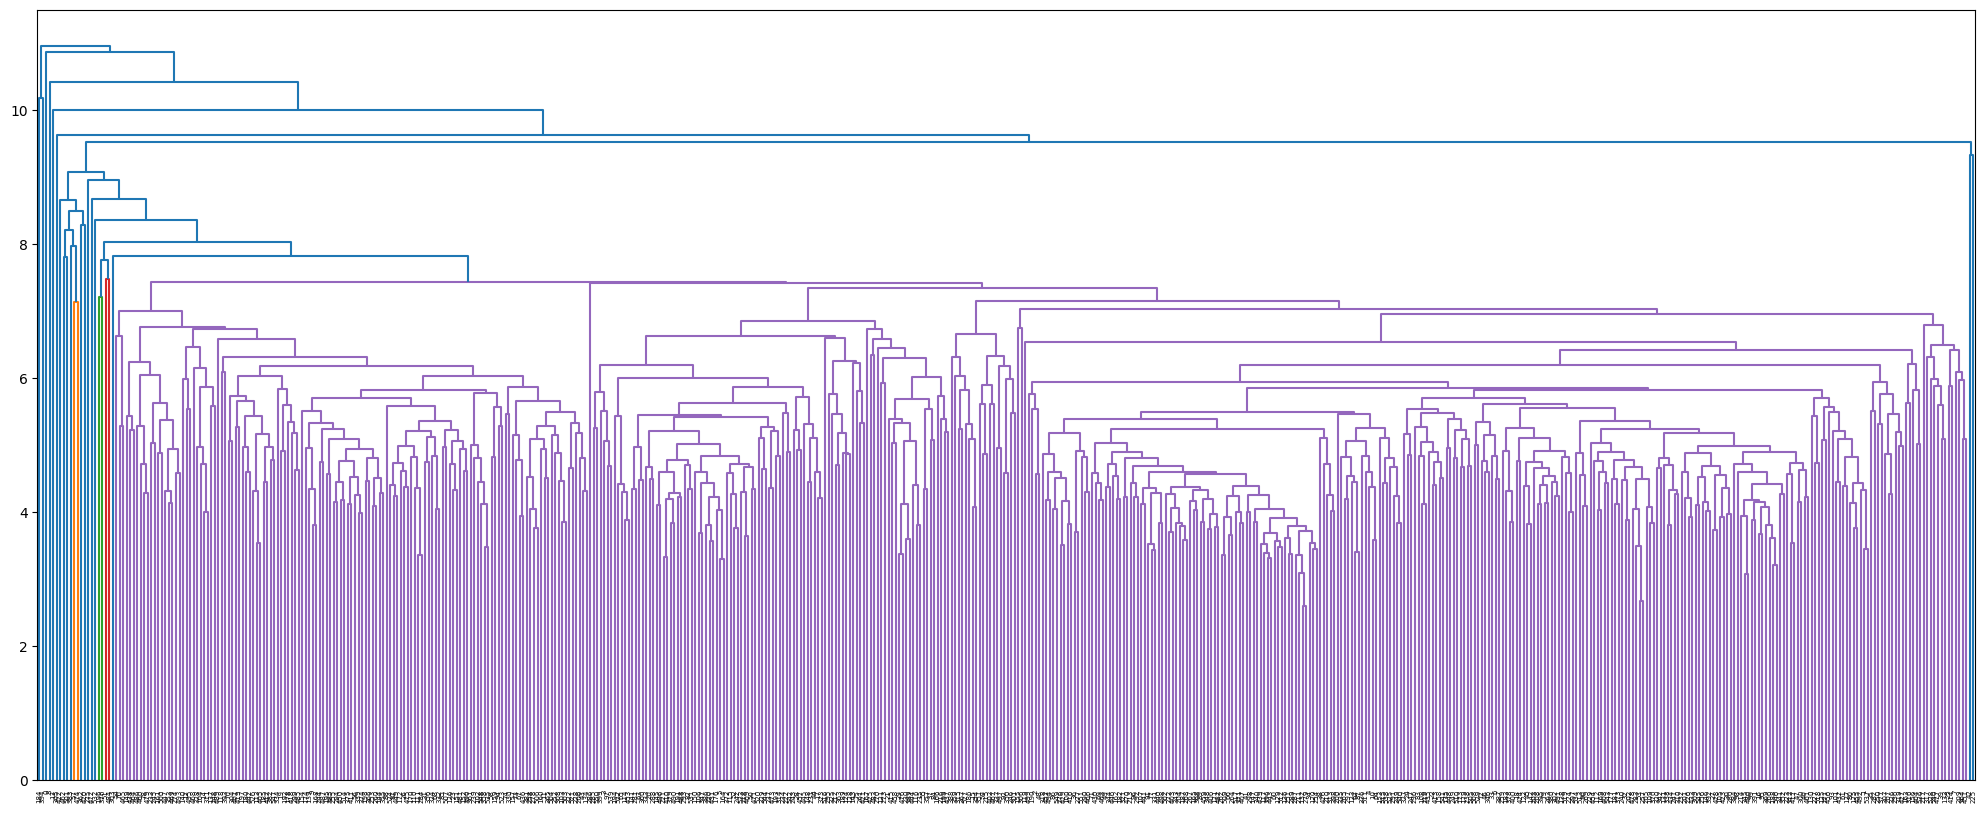

In [110]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [117]:
from scipy.cluster.hierarchy import cut_tree

labels = cut_tree(Z, n_clusters=5)
labels[:,0]

array([0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,